In [1]:
#一.读取数据
def load_data(fname):
    with open(fname , 'r', encoding='utf-8') as f:
        text = f.read()

    data = text.split()
    return data

text = load_data('data/split.txt')
print("前十个词：{}".format(text[:10]))

#二.数据预处理
#构造词典及映射
vocab = set(text) #set() 函数创建一个无序不重复元素集，可进行关系测试，删除重复数据
vocab_to_int = {w : idx for (idx , w) in enumerate(vocab)}  #enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中。
int_to_vocab = {idx : w for (idx , w) in enumerate(vocab)}

print('Total words: {}'.format(len(text)))
print('Vocab size: {}'.format(len(vocab)))

#转换文本为整数
int_text = [vocab_to_int[w] for w in text]
print("int_text:" , int_text)

#三.构建网络
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

# # Check TensorFlow Version
# assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
# print('TensorFlow版本: {}'.format(tf.__version__))
#
# # Check for a GPU
# if not tf.test.gpu_device_name():
#     warnings.warn('未发现GPU，请使用GPU进行训练！')
# else:
#     print('默认GPU设备: {}'.format(tf.test.gpu_device_name()))

#输入层
def get_input():
    inputs = tf.placeholder(tf.int32 , [None , None] , name = "inputs")
    targets = tf.placeholder(tf.int32 , [None , None] , name = "targets")
    learning_rate = tf.placeholder(tf.float32 , name = "learning_rate")
    return inputs , targets , learning_rate

#RNN cell
def get_init_cell(batch_size , rnn_size):
    #rnn_size为RNN隐层神经元个数
    lstm = rnn.BasicLSTMCell(rnn_size)
    cell = rnn.MultiRNNCell([lstm]) #https://www.leiphone.com/news/201709/QJAIUzp0LAgkF45J.html

    initial_state = cell.zero_state(batch_size , tf.float32) #返回[batch_size, len(cells)]这个函数只是用来生成初始化值的
    initial_state = tf.identity(initial_state , "initial_state") #它返回一个和输入的 tensor 大小和数值都一样的 tensor ,类似于 y=x 操作
    return cell , initial_state

#word_embedding
def get_embed(input_data , vocab_size , embed_dim):
    #单词太多需要embedding
    # input_data: 输入的tensor
    # vocab_size: 词汇表大小
    # embed_dim: 嵌入维度
    embedding = tf.Variable(tf.random_uniform([vocab_size, embed_dim], -1, 1))
    embed = tf.nn.embedding_lookup(embedding, input_data) #embedding_lookup（params, ids）函数的用法主要是选取一个张量里面索引对应的元素。params可以是张量也可以是数组等，id就是对应的索引。

    return embed

#Build RNN
def build_rnn(cell , inputs):
    #构建RNN模型
    # cell: RNN单元
    # inputs: 输入的batch
    outputs, final_state = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32) #output与h其实为一样的，需要将output进行其他操作才能得到真正输出

    final_state = tf.identity(final_state, 'final_state')
    return outputs, final_state

#Build Neural Network
def build_nn(cell , rnn_size , input_data , vocab_size , embed_dim):
    '''
       构建神经网络，将RNN层与全连接层相连

       参数:
       ---
       cell: RNN单元
       rnn_size: RNN隐层结点数量
       input_data: input tensor
       vocab_size
       embed_dim: 嵌入层大小
       '''
    embed = get_embed(input_data , vocab_size , embed_dim)
    outputs , final_state = build_rnn(cell , embed)

    logits = tf.contrib.layers.fully_connected(outputs , vocab_size , activation_fn = None)

    return logits , final_state

#构造batch
    #
    # 构造batch
    # 在这里，我们将采用以下方式进行batch的构造，如果我们有一个1-20的序列，传入参数batch_size=3, seq_length=2的话，希望返回以下一个四维的向量。
    #
    # 分为了三个batch，每个batch中包含了输入和对应的目标输出。 get_batches([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 3, 2)
    #
    # First Batch
    # [
    #
    # Batch of Input
    # [[ 1  2], [ 7  8], [13 14]]
    # # Batch of targets
    # [[ 2  3], [ 8  9], [14 15]]
    # ]
    #
    # Second Batch
    # [
    #
    # # Batch of Input
    # [[ 3  4], [ 9 10], [15 16]]
    # # Batch of targets
    # [[ 4  5], [10 11], [16 17]]
    # ]
    #
    # Third Batch
    # [
    #
    # # Batch of Input
    # [[ 5  6], [11 12], [17 18]]
    # # Batch of targets
    # [[ 6  7], [12 13], [18  1]]
    # ] ]
def get_batches(int_text, batch_size, seq_length):
    '''
    构造batch
    '''
    batch = batch_size * seq_length
    n_batch = len(int_text) // batch

    int_text = np.array(int_text[:batch * n_batch])  # 保留能构成完整batch的数量

    int_text_targets = np.zeros_like(int_text)
    int_text_targets[:-1], int_text_targets[-1] = int_text[1:], int_text[0]

    # 切分
    x = np.split(int_text.reshape(batch_size, -1), n_batch, -1)
    y = np.split(int_text_targets.reshape(batch_size, -1), n_batch, -1)

    return np.stack((x, y), axis=1)  # 组合

#四.模型训练
num_epochs = 1000
batch_size = 64
rnn_size = 512
embed_dim = 200 #Embedding Dimension Size
seq_length = 20
learning_rate = 0.0001
show_every_n_batches = 100
loss_array = []

from tensorflow.contrib import seq2seq

train_graph = tf.Graph()
with train_graph.as_default():
    vocab_size = len(int_to_vocab)
    input_text , targets , lr = get_input() #输入tensor
    input_data_shape = tf.shape(input_text)

    #初始化RNN
    cell , initial_state = get_init_cell(input_data_shape[0] , rnn_size) #input_data_shape[0]为mini_batch的size
    logits , final_state = build_nn(cell , rnn_size , input_text , vocab_size , embed_dim)

    #计算softmax层概率
    probs = tf.nn.softmax(logits , name = "probs")

    #损失函数
    cost = seq2seq.sequence_loss(logits , targets , tf.ones([input_data_shape[0] , input_data_shape[1]]))

    #优化函数
    optimizer = tf.train.AdamOptimizer(lr)

    #梯度裁剪
    gradients = optimizer.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad , -1. , 1.), var) for grad , var in gradients if grad is not None]
    train_op = optimizer.apply_gradients(capped_gradients)

    #获取batch
    batches = get_batches(int_text , batch_size , seq_length)
    save_dir = './save'

    with tf.Session(graph = train_graph) as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(num_epochs):
            state = sess.run(initial_state , {input_text : batches[0][0]})

            for batch_i , (x , y) in enumerate(batches):
                feed = {
                    input_text : x ,
                    targets : y ,
                    initial_state : state ,
                    lr : learning_rate
                }
                train_loss , state , _ = sess.run([cost , final_state , train_op] , feed)
                loss_array.append(train_loss)

                # 每训练一定阶段对结果进行打印
                if (epoch * len(batches) + batch_i) % show_every_n_batches == 0:
                    print('Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                        epoch,
                        batch_i,
                        len(batches),
                        train_loss))

        #绘制损失图
        x_axis = range(len(loss_array))
        plt.plot(x_axis, loss_array)
        plt.title('loss for each batch')
        plt.show()
        # 保存模型
        saver = tf.train.Saver()
        saver.save(sess, save_dir)
        print('Model Trained and Saved')


前十个词：['疯狂', '世界', '.', '如果说', '了', '后悔', '.', '是不是', '一切', '就']
Total words: 103882
Vocab size: 11143
int_text: [10147, 3189, 10603, 9678, 7156, 7337, 10603, 8, 8025, 4315, 402, 5752, 8486, 8486, 10603, 6424, 1006, 2435, 10603, 7999, 1006, 4293, 8486, 8486, 10603, 9005, 5464, 3415, 3189, 10603, 9633, 11071, 9937, 1690, 7785, 8486, 8486, 10603, 8943, 5588, 1751, 10603, 1457, 7542, 1751, 8486, 8486, 10603, 8943, 6645, 5787, 6645, 5787, 839, 10603, 9350, 3415, 10147, 3189, 8486, 8486, 10603, 10035, 3248, 8486, 10035, 1355, 8486, 10035, 3625, 7207, 7500, 7570, 8486, 8486, 10603, 8943, 6645, 5787, 6645, 5787, 839, 8486, 9350, 3415, 10147, 3189, 8486, 8486, 10603, 7631, 9663, 1010, 8486, 306, 7156, 8943, 8486, 1457, 8654, 4735, 8943, 7989, 8486, 8486, 10603, 5787, 7156, 1010, 3629, 8486, 9349, 10787, 1010, 7500, 8258, 8486, 8486, 10603, 1010, 9663, 7775, 1926, 8486, 9710, 2649, 3359, 5676, 2655, 10635, 8486, 8486, 10603, 6512, 9663, 1983, 8218, 11002, 7500, 3600, 8486, 6747, 1081, 2649, 1063

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Epoch   0 Batch    0/81   train_loss = 9.322
Epoch   1 Batch   19/81   train_loss = 6.794
Epoch   2 Batch   38/81   train_loss = 6.612
Epoch   3 Batch   57/81   train_loss = 6.571
Epoch   4 Batch   76/81   train_loss = 6.632
Epoch   6 Batch   14/81   train_loss = 6.387
Epoch   7 Batch   33/81   train_loss = 6.510
Epoch   8 Batch   52/81   train_loss = 6.509
Epoch   9 Batch   71/81   train_loss = 6.439
Epoch  11 Batch    9/81   train_loss = 6.396
Epoch  12 Batch   28/81   train_loss = 6.319
Epoch  13 Batch   47/81   train_loss = 6.171
Epoch  14 Batch   66/81   train_loss = 6.141
Epoch  16 Batch    4/81   train_loss = 6.147
Epoch  17 Batch   23/81   train_loss = 6.211
Epoch  18 Batch   42/81   train_loss = 6.155
Epoch  19 Batch   61/81   train_loss = 5.970
Epo

Epoch 213 Batch   47/81   train_loss = 2.307
Epoch 214 Batch   66/81   train_loss = 2.023
Epoch 216 Batch    4/81   train_loss = 2.227
Epoch 217 Batch   23/81   train_loss = 2.010
Epoch 218 Batch   42/81   train_loss = 2.191
Epoch 219 Batch   61/81   train_loss = 2.020
Epoch 220 Batch   80/81   train_loss = 1.989
Epoch 222 Batch   18/81   train_loss = 2.164
Epoch 223 Batch   37/81   train_loss = 1.977
Epoch 224 Batch   56/81   train_loss = 2.039
Epoch 225 Batch   75/81   train_loss = 1.973
Epoch 227 Batch   13/81   train_loss = 2.090
Epoch 228 Batch   32/81   train_loss = 1.879
Epoch 229 Batch   51/81   train_loss = 2.030
Epoch 230 Batch   70/81   train_loss = 1.787
Epoch 232 Batch    8/81   train_loss = 1.962
Epoch 233 Batch   27/81   train_loss = 1.949
Epoch 234 Batch   46/81   train_loss = 1.905
Epoch 235 Batch   65/81   train_loss = 1.812
Epoch 237 Batch    3/81   train_loss = 1.906
Epoch 238 Batch   22/81   train_loss = 1.895
Epoch 239 Batch   41/81   train_loss = 1.895
Epoch 240 

Epoch 439 Batch   41/81   train_loss = 0.520
Epoch 440 Batch   60/81   train_loss = 0.472
Epoch 441 Batch   79/81   train_loss = 0.595
Epoch 443 Batch   17/81   train_loss = 0.523
Epoch 444 Batch   36/81   train_loss = 0.506
Epoch 445 Batch   55/81   train_loss = 0.477
Epoch 446 Batch   74/81   train_loss = 0.478
Epoch 448 Batch   12/81   train_loss = 0.535
Epoch 449 Batch   31/81   train_loss = 0.523
Epoch 450 Batch   50/81   train_loss = 0.466
Epoch 451 Batch   69/81   train_loss = 0.435
Epoch 453 Batch    7/81   train_loss = 0.473
Epoch 454 Batch   26/81   train_loss = 0.478
Epoch 455 Batch   45/81   train_loss = 0.516
Epoch 456 Batch   64/81   train_loss = 0.432
Epoch 458 Batch    2/81   train_loss = 0.431
Epoch 459 Batch   21/81   train_loss = 0.470
Epoch 460 Batch   40/81   train_loss = 0.385
Epoch 461 Batch   59/81   train_loss = 0.408
Epoch 462 Batch   78/81   train_loss = 0.408
Epoch 464 Batch   16/81   train_loss = 0.457
Epoch 465 Batch   35/81   train_loss = 0.432
Epoch 466 

Epoch 665 Batch   35/81   train_loss = 0.189
Epoch 666 Batch   54/81   train_loss = 0.214
Epoch 667 Batch   73/81   train_loss = 0.206
Epoch 669 Batch   11/81   train_loss = 0.194
Epoch 670 Batch   30/81   train_loss = 0.188
Epoch 671 Batch   49/81   train_loss = 0.186
Epoch 672 Batch   68/81   train_loss = 0.182
Epoch 674 Batch    6/81   train_loss = 0.192
Epoch 675 Batch   25/81   train_loss = 0.207
Epoch 676 Batch   44/81   train_loss = 0.203
Epoch 677 Batch   63/81   train_loss = 0.209
Epoch 679 Batch    1/81   train_loss = 0.154
Epoch 680 Batch   20/81   train_loss = 0.169
Epoch 681 Batch   39/81   train_loss = 0.160
Epoch 682 Batch   58/81   train_loss = 0.193
Epoch 683 Batch   77/81   train_loss = 0.185
Epoch 685 Batch   15/81   train_loss = 0.214
Epoch 686 Batch   34/81   train_loss = 0.176
Epoch 687 Batch   53/81   train_loss = 0.171
Epoch 688 Batch   72/81   train_loss = 0.174
Epoch 690 Batch   10/81   train_loss = 0.177
Epoch 691 Batch   29/81   train_loss = 0.155
Epoch 692 

Epoch 891 Batch   29/81   train_loss = 0.129
Epoch 892 Batch   48/81   train_loss = 0.153
Epoch 893 Batch   67/81   train_loss = 0.155
Epoch 895 Batch    5/81   train_loss = 0.144
Epoch 896 Batch   24/81   train_loss = 0.140
Epoch 897 Batch   43/81   train_loss = 0.143
Epoch 898 Batch   62/81   train_loss = 0.166
Epoch 900 Batch    0/81   train_loss = 0.125
Epoch 901 Batch   19/81   train_loss = 0.171
Epoch 902 Batch   38/81   train_loss = 0.127
Epoch 903 Batch   57/81   train_loss = 0.187
Epoch 904 Batch   76/81   train_loss = 0.149
Epoch 906 Batch   14/81   train_loss = 0.125
Epoch 907 Batch   33/81   train_loss = 0.145
Epoch 908 Batch   52/81   train_loss = 0.150
Epoch 909 Batch   71/81   train_loss = 0.166
Epoch 911 Batch    9/81   train_loss = 0.114
Epoch 912 Batch   28/81   train_loss = 0.161
Epoch 913 Batch   47/81   train_loss = 0.151
Epoch 914 Batch   66/81   train_loss = 0.147
Epoch 916 Batch    4/81   train_loss = 0.143
Epoch 917 Batch   23/81   train_loss = 0.142
Epoch 918 

<Figure size 640x480 with 1 Axes>

Model Trained and Saved


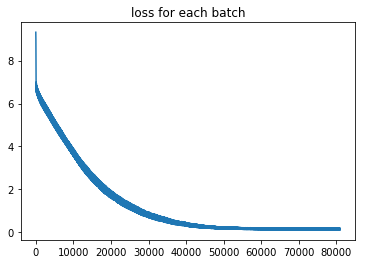

In [3]:
%matplotlib inline
#绘制损失图
x_axis = range(len(loss_array))
plt.plot(x_axis, loss_array)
plt.title('loss for each batch')
plt.show()

In [38]:

#五.使用模型
def get_tensors(loaded_graph):
    '''
    获取模型训练结果参数
    参数
    ---
    loaded_graph: 从文件加载的tensroflow graph
    '''
    inputs = loaded_graph.get_tensor_by_name('inputs:0')
    initial_state = loaded_graph.get_tensor_by_name('initial_state:0')
    final_state = loaded_graph.get_tensor_by_name('final_state:0')
    probs = loaded_graph.get_tensor_by_name('probs:0')
    return inputs, initial_state, final_state, probs


def pick_word(probabilities, int_to_vocab):
    '''
    选择单词进行文本生成，用来以一定的概率生成下一个词
    参数
    ---
    probabilities: Probabilities of the next word
    int_to_vocab: 映射表
    '''
#     print("len(probabilities)",len(probabilities))
#     print("probabilities",probabilities)
    result = np.random.choice(len(probabilities), 1 , p=probabilities) #根据probably从所有里选50个
#     print("result", result[0])
    return int_to_vocab[result[0]]


# 生成文本的长度
gen_length = 300

# 定义冷启动的单词
prime_word = '我'

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # 加载模型
    loader = tf.train.import_meta_graph(save_dir + '.meta')
    loader.restore(sess, save_dir)

    # 获取训练的结果参数
    input_text, initial_state, final_state, probs = get_tensors(loaded_graph)

    # Sentences generation setup
    gen_sentences = [prime_word]
    prev_state = sess.run(initial_state, {input_text: np.array([[1]])})
#     print("prev_state" , prev_state)

    # 生成句子
    for n in range(gen_length):
        dyn_input = [[vocab_to_int[word] for word in gen_sentences[-seq_length:]]]
        dyn_seq_length = len(dyn_input[0])
#         print("dyn_input" , dyn_input)
#         print("dyn_seq_length" , dyn_seq_length)

        # 预测
        probabilities, prev_state = sess.run(
            [probs, final_state],
            {input_text: dyn_input, initial_state: prev_state})
#         print("probabilities" , probabilities)
#         print("probabilities of one" , probabilities[0][dyn_seq_length-1])
#         print("final_state" , prev_state)
        
        
        pred_word = pick_word(probabilities[0][dyn_seq_length-1], int_to_vocab)
#         print("pred_word" , pred_word)

        gen_sentences.append(pred_word)
#         print("gen_sentences" , gen_sentences)
#         print("*****************")
    
    lyrics = ' '.join(gen_sentences)
    lyrics = lyrics.replace(';', '\n')
    lyrics = lyrics.replace('.', ' ')
    lyrics = lyrics.replace(' ', '')
        
    print(lyrics)

INFO:tensorflow:Restoring parameters from ./save
我的天使
给我快乐的天使

甚至我学会了飞翔
飞过人间

只是忘了我
吻
你啊
还能看到
又一次
你的手
我的烦恼
我已经决定了
我又
为什么
请你爱才说
啦
迟到眼泪
还忘
你在
那里我又看见
当一个人

在风中来的温柔

让爱变成了
只是和世界
的幻想
你都没空


那是悲伤的未来
不是为
别人曾会看见

快乐很勇敢的那会

别让人变成最痛的
被你的朋友

我需要寂寞的寂寞
要怎么睡
生活
被世界

这世界
甘愿搁浅明天
你曾这样
的青春
轻轻的改变
生活
消灭
如果这生命就得寂寞
那时间是如何该出现
如果邪恶得的世界里如此的世界纪录紧紧是现实的是
是否院子你的形状在我身边这不是我要的岁月这是我
能说我对你的手经过小舢板
那个场景我将过的门打开是谁在你的人生是我

你身边雨纷纷
旧故里草木深我说让我听见

